# Genre Classification using Supervised Machine Learning Models

This notebook contains the code to classify tracks with a genre by (1) investigating possible predictive input features and (2) predicting genre labels using 3 supervised classification models: K-Nearest Neighbors (KNN), support vector machines (SVM) and random forest (RF).

In [1]:
import warnings
from collections import Counter

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.tree import plot_tree
from xgboost import XGBClassifier
import xgboost as xgb

from imblearn.pipeline import Pipeline
from sklearnex import patch_sklearn

import shap
import joblib
from tqdm import tqdm


warnings.filterwarnings("ignore")
patch_sklearn()

d:\Justin\Documents\Learn\Eskwelabs-DS\sprint-3\venv-eskwelabs-ds-s3\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
d:\Justin\Documents\Learn\Eskwelabs-DS\sprint-3\venv-eskwelabs-ds-s3\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour

## Read and check values of playlist sets

### Set genres for prediction

In [2]:
genre_names = ["rock", "indie", "soul", "pop"]

### Read and check tracks data for each genre

Collect genre playlist data

In [3]:
playlist_df_list = []
for genre in tqdm(genre_names):
    pdf = pd.read_csv('../data/playlists/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower()
    playlist_df_list.append(pdf)

100%|██████████| 4/4 [00:00<00:00, 170.12it/s]


Collect genre track data

In [4]:
track_df_list = []
for genre in tqdm(genre_names):
    tdf = pd.read_csv('../data/playlists/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf = tdf[~tdf.duplicated(subset=['track_id'])] # keep only 1 track id, relevant for older playlist data 
    tdf['genre'] =  genre.lower()
    track_df_list.append(tdf)

100%|██████████| 4/4 [00:00<00:00, 40.08it/s]


Concatenate playlist data

In [5]:
playlist_df = pd.concat(playlist_df_list)
playlist_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWXRqgorJj26U,Rock Classics,173,spotify,Spotify,9810263,rock
1,37i9dQZF1DX1rVvRgjX59F,90s Rock Anthems,100,spotify,Spotify,4555610,rock
2,37i9dQZF1DX1spT6G94GFC,80s Rock Anthems,80,spotify,Spotify,2143197,rock
3,37i9dQZF1DX2sUQwD7tbmL,Feel-Good Indie Rock,120,spotify,Spotify,1523552,rock
4,37i9dQZF1EQpj7X7UK8OOF,Rock Mix,50,spotify,Spotify,1462897,rock


In [6]:
playlist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   playlist_id            387 non-null    object
 1   playlist_name          387 non-null    object
 2   playlist_total_tracks  387 non-null    int64 
 3   owner_id               387 non-null    object
 4   owner_name             387 non-null    object
 5   total_followers        387 non-null    int64 
 6   genre                  387 non-null    object
dtypes: int64(2), object(5)
memory usage: 24.2+ KB


Get genre playlist tally

In [7]:
playlist_df['genre'].value_counts()

pop      100
rock      97
indie     96
soul      94
Name: genre, dtype: int64

Concatenate playlist data

In [8]:
tracks_df = pd.concat(track_df_list)
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,genre
0,57JVGBtBLCfHw2muk5416J,Another One Bites The Dust - Remastered 2011,1dfeR4HaWDbWqFHLkxsg1d,Queen,6wPXUmYJ9mOWrKlLzZ5cCa,214653,1980-06-27,74,0.933,0.528,...,0.0,0.1620,0.1120,0.32900,0.163,0.756,109.975,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock
4,2zYzyRzz6pRmhPzyfMEC8s,Highway to Hell,711MCceyCBcFnzjGY4Q7Un,AC/DC,10v912xgTZbjAtYfyKWJCS,208400,1979-07-27,84,0.574,0.913,...,0.0,0.1330,0.0610,0.00158,0.156,0.423,115.728,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock
8,3YBZIN3rekqsKxbJc9FZko,Paradise City,3qm84nBOXUEQ2vnTfUTTFC,Guns N' Roses,3I9Z1nDCL4E0cP62flcbI5,405640,1987-07-21,79,0.273,0.952,...,1.0,0.0843,0.0169,0.01110,0.142,0.472,100.271,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock
12,39shmbIHICJ2Wxnk1fPSdz,Should I Stay or Should I Go - Remastered,3RGLhK1IP9jnYFH4BRFJBS,The Clash,1ZH5g1RDq3GY1OvyD0w0s2,188986,1982,79,0.743,0.836,...,1.0,0.1160,0.0804,0.00000,0.384,0.820,113.375,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock
16,2Cdvbe2G4hZsnhNMKyGrie,I Love Rock 'N Roll,1Fmb52lZ6Jv7FMWXXTPO3K,Joan Jett & The Blackhearts,555qwe1qUgLdee80TZ2CQt,175173,1981-11-18,77,0.535,0.716,...,1.0,0.0431,0.3260,0.00000,0.659,0.901,94.379,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock


In [9]:
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5911 entries, 0 to 1317
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          5911 non-null   object 
 1   track_name        5911 non-null   object 
 2   artist_id         5911 non-null   object 
 3   artist_name       5911 non-null   object 
 4   album_id          5911 non-null   object 
 5   duration          5911 non-null   int64  
 6   release_date      5911 non-null   object 
 7   popularity        5911 non-null   int64  
 8   danceability      5910 non-null   float64
 9   energy            5910 non-null   float64
 10  key               5910 non-null   float64
 11  loudness          5910 non-null   float64
 12  mode              5910 non-null   float64
 13  speechiness       5910 non-null   float64
 14  acousticness      5910 non-null   float64
 15  instrumentalness  5910 non-null   float64
 16  liveness          5910 non-null   float64


Get genre tracks tally

In [10]:
tracks_df['genre'].value_counts()

rock     1877
indie    1413
pop      1318
soul     1303
Name: genre, dtype: int64

## Refine the training data

**Refinement 1**

Get only *top 10 most followed playlists* per genre.

>Q: Try out keeping top 15 most followed playlists and see what results youll get. 

In [11]:
#.head() will show top 10 followed playlists
# since playlists csv is already ordered by decreasing total followers
top_playlists_df = playlist_df.groupby(['genre']).head(10)
top_playlists_df

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWXRqgorJj26U,Rock Classics,173,spotify,Spotify,9810263,rock
1,37i9dQZF1DX1rVvRgjX59F,90s Rock Anthems,100,spotify,Spotify,4555610,rock
2,37i9dQZF1DX1spT6G94GFC,80s Rock Anthems,80,spotify,Spotify,2143197,rock
3,37i9dQZF1DX2sUQwD7tbmL,Feel-Good Indie Rock,120,spotify,Spotify,1523552,rock
4,37i9dQZF1EQpj7X7UK8OOF,Rock Mix,50,spotify,Spotify,1462897,rock
5,37i9dQZF1DX49jUV2NfGku,Rock Solid,80,spotify,Spotify,1285451,rock
6,37i9dQZF1DWZU5DGR2xCSH,Iconos del Rock Argentino,80,spotify,Spotify,994475,rock
7,3Ho3iO0iJykgEQNbjB2sic,"Classic Rock 70s 80s 90s, Rock Classics - 70s ...",402,juan20150,Juan20150,882614,rock
8,37i9dQZF1DWWJOmJ7nRx0C,Rock Hard,155,spotify,Spotify,804162,rock
9,37i9dQZF1DX0rCrO4CFRfM,Acoustic Rock,50,spotify,Spotify,764832,rock


In [12]:
# Filter keeping only top 10 playlists
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]

In [13]:
# Get new genre tracks tally
tracks_df['genre'].value_counts()

rock     1237
indie     735
soul      732
pop       436
Name: genre, dtype: int64

**Refinement 2**

Remove tracks that appear in different genre playlists - get only *unique tracks* per genre

In [14]:
# View duplicated
# Use artist id and track name to ensure uniqueness
tracks_df[tracks_df.duplicated(subset=['artist_id','track_name'])]

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,genre
324,1hKdDCpiI9mqz1jVHRKG0E,Enter Sandman,2ye2Wgw4gimLv2eAKyk1NB,Metallica,37lWyRxkf3wQHCOlXM5WfX,331573,1991-08-12,0,0.579,0.824,...,0.0,0.0300,0.00206,0.009030,0.0590,0.635,123.331,37i9dQZF1DX1rVvRgjX59F,90s Rock Anthems,rock
326,3HfB5hBU0dmBt8T0iCmH42,Creep,4Z8W4fKeB5YxbusRsdQVPb,Radiohead,6AZv3m27uyRxi8KyJSfUxL,235666,1993-04-23,0,0.532,0.344,...,1.0,0.0350,0.00563,0.000473,0.1150,0.126,91.834,37i9dQZF1DX1rVvRgjX59F,90s Rock Anthems,rock
331,5yEPxDjbbzUzyauGtnmVEC,Bitter Sweet Symphony,2cGwlqi3k18jFpUyTrsR84,The Verve,2okCg9scHue9GNELoB8U9g,358426,1997-09-29,1,0.389,0.889,...,1.0,0.0442,0.04150,0.000000,0.4630,0.524,171.121,37i9dQZF1DX1rVvRgjX59F,90s Rock Anthems,rock
350,4Qbjmdlv1eZDD1u8SWe1pt,Alive,1w5Kfo2jwwIPruYS2UWh56,Pearl Jam,029dnuRwPEn8biaR5QC59w,341160,1991,0,0.298,0.826,...,1.0,0.0405,0.00536,0.000015,0.4400,0.529,75.427,37i9dQZF1DX1rVvRgjX59F,90s Rock Anthems,rock
411,7qQnBfwXrw2tZNFG4Uf57N,Livin' On A Prayer,58lV9VcRSjABbAbfWS6skp,Bon Jovi,0C8Poy7zwJ1kQh2sldyvHm,250626,2010-01-01,0,0.520,0.887,...,1.0,0.0349,0.06650,0.000179,0.1860,0.793,122.528,37i9dQZF1DX1spT6G94GFC,80s Rock Anthems,rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2dLLR6qlu5UJ5gk0dKz0h3,Royals,163tK9Wjr9P9DmM0AVK7lm,Lorde,0rmhjUgoVa17LZuS8xWQ3v,190185,2013-09-27,80,0.674,0.428,...,1.0,0.1220,0.12100,0.000000,0.1320,0.337,84.878,37i9dQZF1DWTwnEm1IYyoj,Soft Pop Hits,pop
95,4T6FWA703h6H7zk1FoSARw,New Light,0hEurMDQu99nJRq8pTxO14,John Mayer,2JmfwvRDitJlTUoLCkp61z,217426,2021-07-16,76,0.826,0.694,...,1.0,0.0315,0.31600,0.028500,0.0740,0.852,123.932,37i9dQZF1DWTwnEm1IYyoj,Soft Pop Hits,pop
364,7bSlafYF33JHLoB9NtsL9V,Look At Us Now (Honeycomb),0ZUdYzRCIrxbsd80MmGMqo,Daisy Jones & The Six,4ouqACcnzsOvtUlnj5abyo,332386,2023-03-02,77,0.323,0.761,...,1.0,0.0479,0.00942,0.000586,0.0827,0.466,141.282,37i9dQZF1DWUa8ZRTfalHk,Pop Rising,pop
575,0Oqc0kKFsQ6MhFOLBNZIGX,Doin' Time,00FQb4jTyendYWaN8pK0wa,Lana Del Rey,5XpEKORZ4y6OrCZSKsi46A,202192,2019-08-30,83,0.641,0.559,...,0.0,0.0355,0.40400,0.004020,0.0937,0.523,144.982,37i9dQZF1DX3WvGXE8FqYX,Women of Pop,pop


>Q: Which genres have the highest number of duplicated tracks (tracks classified under two or more genres)?

In [15]:
duplicated_tracks_df = tracks_df[tracks_df.duplicated(subset=['artist_id', 'track_name'], keep=False)]
duplicated_tracks_df.groupby('genre')['track_id'].count()

genre
indie     89
pop        7
rock     204
soul      13
Name: track_id, dtype: int64

>Q: Which tracks were classified to the most number of genres?

In [16]:
duplicated_tracks_df.groupby(['track_id', 'track_name'])[['genre']]\
                    .agg(count=('genre', 'count'),
                         genres=('genre', lambda x: list(x)))\
                    .sort_values(by='count', ascending=False)

,,count,genres
track_id,track_name,,
4asjU3sDnn3002bTJIg2vZ,Missed the Boat,2,"[rock, indie]"
6CES1554HcWMIVroJfmmBm,Way It Goes,2,"[rock, indie]"
14e46mURUUwB3i2vTe1gFz,Astrovan,2,"[rock, indie]"
70wYA8oYHoMzhRRkARoMhU,When You Were Young,2,"[rock, indie]"
2dLLR6qlu5UJ5gk0dKz0h3,Royals,2,"[indie, pop]"
...,...,...,...
3HQdwlovzULm18PjvlA5wz,Eyes,1,[rock]
3HfB5hBU0dmBt8T0iCmH42,Creep,1,[rock]
3McUZkVgVyzvYCdy4aIo3R,Bitter,1,[rock]


In [17]:
# Filter non-uniquely listed tracks
tracks_df = tracks_df.drop_duplicates(subset=['artist_id','track_name'])
tracks_df.shape

(2978, 22)

In [18]:
# Get new genre tracks tally
tracks_df['genre'].value_counts()

rock     1169
soul      724
indie     656
pop       429
Name: genre, dtype: int64

## Compare histogram of features

Choose two genres to compare

In [19]:
compare_genres = ['pop','alternative']

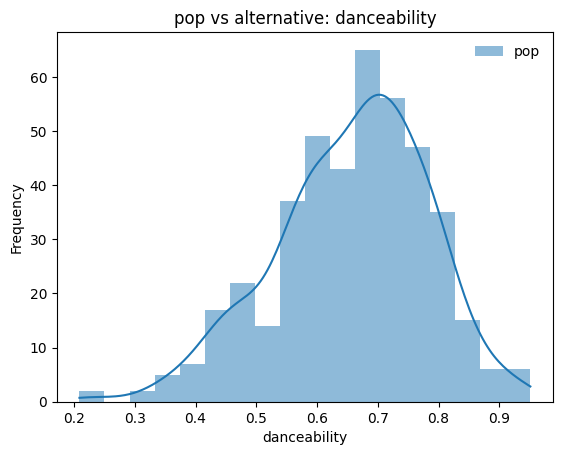

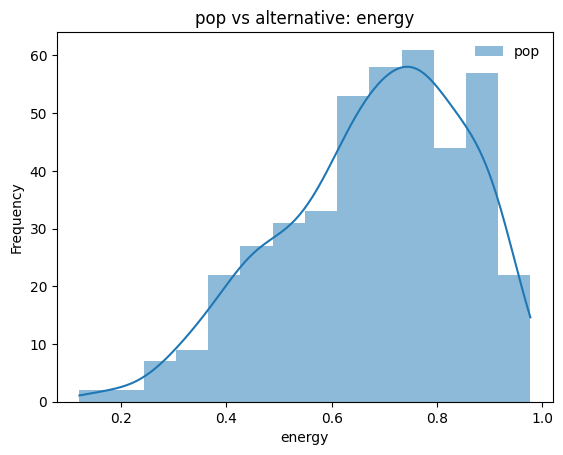

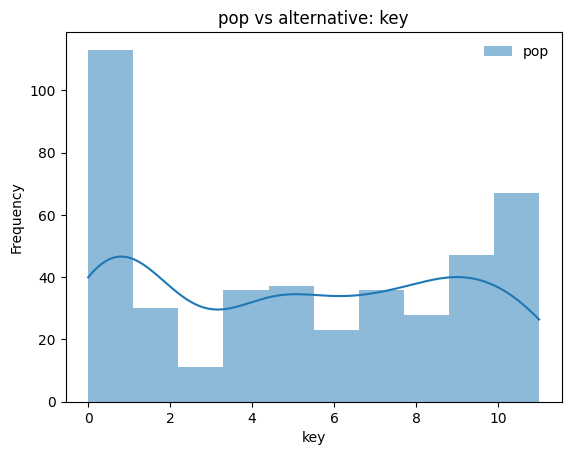

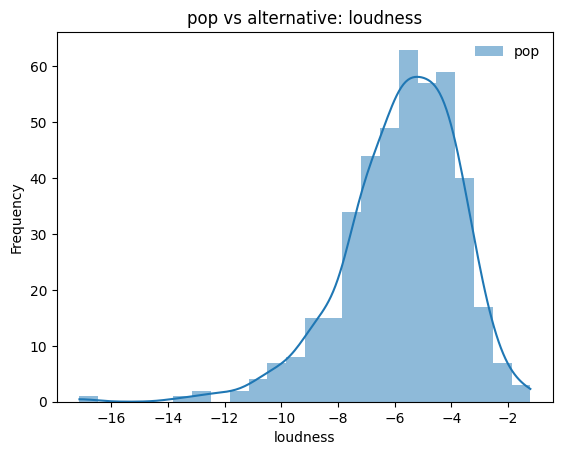

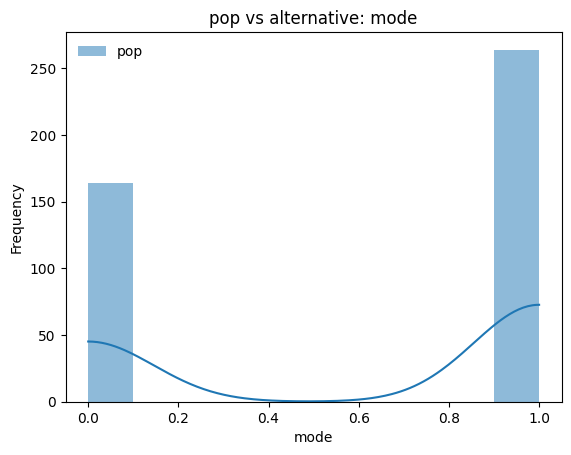

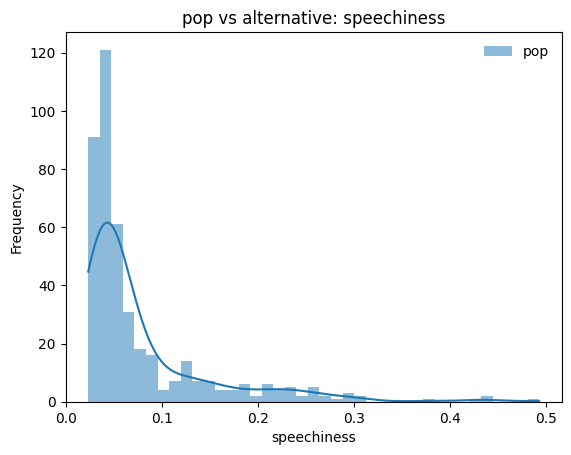

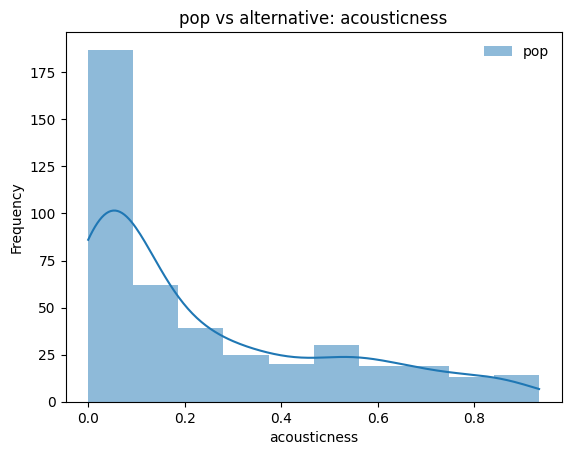

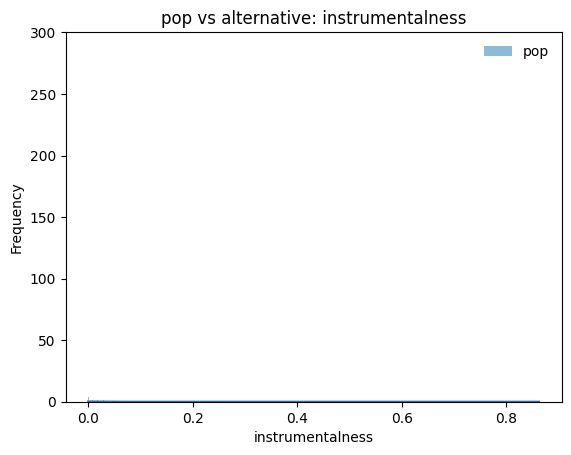

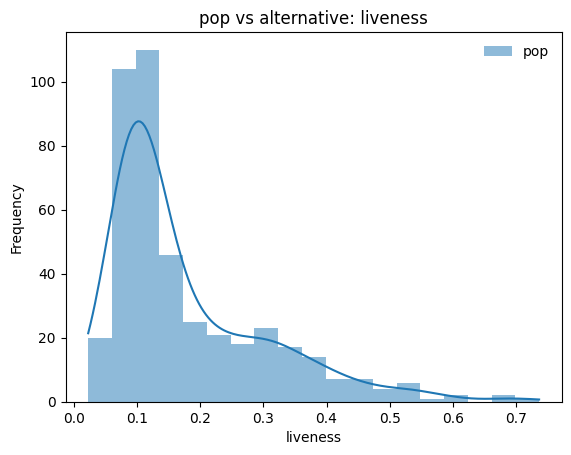

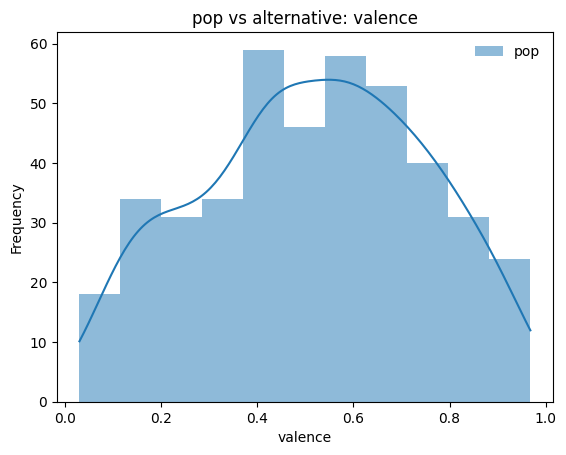

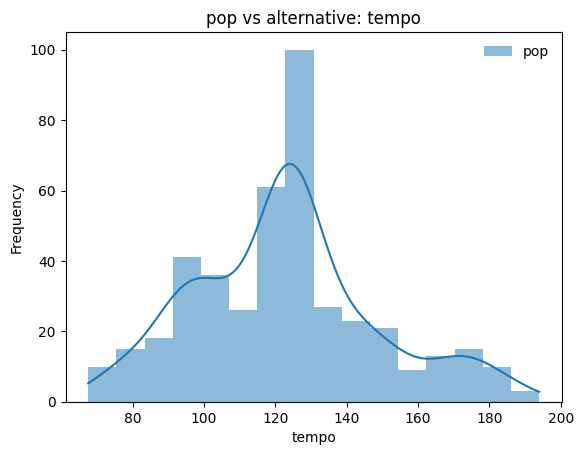

In [20]:
for col in ['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo']:
    fig,ax = plt.subplots()
    for genre in compare_genres:
       data = tracks_df[tracks_df['genre']==genre]
       sns.histplot(data[col], ax=ax, label= genre, kde=True, edgecolor='None')
    plt.title(f"{compare_genres[0]} vs {compare_genres[1]}: {col}")
    plt.ylabel('Frequency')
    plt.legend(frameon=False)
    plt.show()

## 3. Feature Engineering

**Categorical Encoding**
Since supervised models only takes in integers as labels, we map genres to numbers

In [21]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,genre,genre_id
0,57JVGBtBLCfHw2muk5416J,Another One Bites The Dust - Remastered 2011,1dfeR4HaWDbWqFHLkxsg1d,Queen,6wPXUmYJ9mOWrKlLzZ5cCa,214653,1980-06-27,74,0.933,0.528,...,0.1620,0.1120,0.32900,0.163,0.756,109.975,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock,2
4,2zYzyRzz6pRmhPzyfMEC8s,Highway to Hell,711MCceyCBcFnzjGY4Q7Un,AC/DC,10v912xgTZbjAtYfyKWJCS,208400,1979-07-27,84,0.574,0.913,...,0.1330,0.0610,0.00158,0.156,0.423,115.728,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock,2
8,3YBZIN3rekqsKxbJc9FZko,Paradise City,3qm84nBOXUEQ2vnTfUTTFC,Guns N' Roses,3I9Z1nDCL4E0cP62flcbI5,405640,1987-07-21,79,0.273,0.952,...,0.0843,0.0169,0.01110,0.142,0.472,100.271,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock,2
12,39shmbIHICJ2Wxnk1fPSdz,Should I Stay or Should I Go - Remastered,3RGLhK1IP9jnYFH4BRFJBS,The Clash,1ZH5g1RDq3GY1OvyD0w0s2,188986,1982,79,0.743,0.836,...,0.1160,0.0804,0.00000,0.384,0.820,113.375,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock,2
16,2Cdvbe2G4hZsnhNMKyGrie,I Love Rock 'N Roll,1Fmb52lZ6Jv7FMWXXTPO3K,Joan Jett & The Blackhearts,555qwe1qUgLdee80TZ2CQt,175173,1981-11-18,77,0.535,0.716,...,0.0431,0.3260,0.00000,0.659,0.901,94.379,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock,2


Build dictionary of label ids for later

In [22]:
genre_lookup = tracks_df[['genre_id','genre']].drop_duplicates()\
                        .sort_values('genre_id')\
                        .set_index('genre_id')\
                        .to_dict()['genre']
genre_lookup 

{0: 'indie', 1: 'pop', 2: 'rock', 3: 'soul'}

Select audio features to use for the model

In [23]:
# Drop missing values
tracks_df.dropna(inplace=True)

In [24]:
# create feature matrix (X)
# pick energy and tempo as features
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
print(len(X),len(y))

2977 2977


Add to matrices

In [25]:
X = tracks_df[feature_cols]
y = tracks_df['genre_id']

Split to train and test set 

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
tracks_df.columns

Index(['track_id', 'track_name', 'artist_id', 'artist_name', 'album_id',
       'duration', 'release_date', 'popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'playlist_id',
       'playlist_name', 'genre', 'genre_id'],
      dtype='object')

## Proportion Chance Criterion

Class Proportions:
          0
rock   1169
indie   656
soul    724
pop     428
Proportion Chance Criterion: 28.26%
1.25 * Proportion Chance Criterion: 35.32%


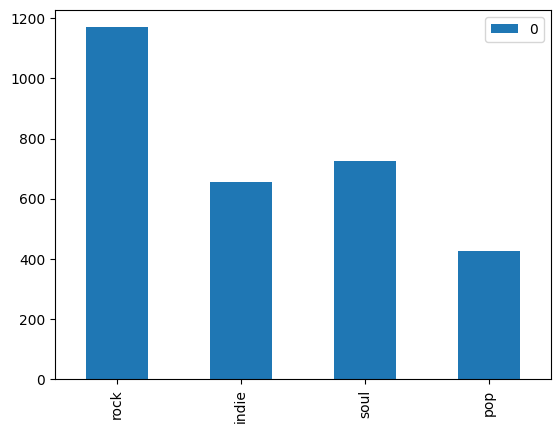

In [28]:
state_counts = Counter(tracks_df['genre'])
data_state = pd.DataFrame.from_dict(state_counts, orient='index')
data_state.plot(kind='bar')

num = (data_state[0]/data_state[0].sum())**2
pcc = num.sum()

print("Class Proportions:\n{}".format(data_state))
print("Proportion Chance Criterion: {:0.2f}%".format(100*pcc))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(125*pcc))


In [29]:
num

rock     0.154195
indie    0.048557
soul     0.059145
pop      0.020669
Name: 0, dtype: float64

## Train Models

### Baseline

#### k-Nearest Neighbors (kNN)

In [30]:
# initialize KNN classifier with 5 nearest neighbors
base_knn = KNeighborsClassifier(n_neighbors=5)

# train the model on the training set
base_knn.fit(X_train, y_train)

# predict labels on the test set
base_knn_y_pred = base_knn.predict(X_test)

# calculate accuracy
base_knn_accuracy = accuracy_score(y_test, base_knn_y_pred)
print(f"Accuracy: {base_knn_accuracy:.4f}")

Accuracy: 0.3658


#### Support Vector Machine

In [31]:
# Instantiate the SVC model
base_svc = SVC()

# Train the model
base_svc.fit(X_train, y_train)

# Predict on the test set
base_svc_y_pred = base_svc.predict(X_test)

# Calculate accuracy score
base_svc_accuracy = accuracy_score(y_test, base_svc_y_pred)
print(f"Accuracy score: {base_svc_accuracy}")

Accuracy score: 0.4312080536912752


#### Random Forest

In [32]:
# Initialize the Random Forest classifier with default hyperparameters
base_rf = RandomForestClassifier(random_state=42)

# Fit the model to the training data
base_rf.fit(X_train, y_train)

# Predict on the test set
base_rf_y_pred = base_rf.predict(X_test)

# Calculate the accuracy of the model
base_rf_accuracy = accuracy_score(y_test, base_rf_y_pred)

# Print the accuracy score
print(f"Accuracy score: {base_rf_accuracy:.4f}")

Accuracy score: 0.5789


### XGBoost

In [33]:
# Define the parameters for the XGBoost model
params = {
    "objective": "multi:softmax",
    "num_class": len(np.unique(y)),
    "eval_metric": "merror",
}

# Convert the data into a DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the model
num_round = 10 # you can change this to more rounds
base_xgb = xgb.train(params, dtrain, num_round)

# Make predictions on the test set
base_xgb_y_pred = base_xgb.predict(dtest)

# Calculate accuracy
base_xgb_accuracy = accuracy_score(y_test, base_xgb_y_pred)
print("Accuracy: %.2f%%" % (base_xgb_accuracy * 100.0))

Accuracy: 59.56%


### Hypertuned

#### k-Nearest Neighbors (kNN)

Perform KNN using `K = [2, 50]` and validate using k-fold cross validation `k = 5`

In [34]:
# Set parameter values
n_neighbors = np.arange(2,51)
k = 5 # for kfold

In [35]:
# Set scaler
scaler = MinMaxScaler()   # RobustScaler would also work

# Initialize model
model = KNeighborsClassifier()

# Initialize cross validation
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize pipeline
pipeline = Pipeline([("scaler", scaler),("knn", model)]) 

Initialize parameter grid

In [36]:
# Initialize parameters
param_grid = {'knn__n_neighbors': n_neighbors}

Find optimal parameters

In [37]:
model_grid_search = GridSearchCV(pipeline, param_grid, verbose = 1, cv = cv)
model_grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             verbose=1)

In [38]:
model_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             verbose=1)

Get best params and scores

In [39]:
print(f"Best hyperparameters: {model_grid_search.best_params_}")
print(f"Train best score: {model_grid_search.best_score_:0.6}")
print(f"Train best score std: {np.std(model_grid_search.cv_results_['mean_test_score']):0.6}")

Best hyperparameters: {'knn__n_neighbors': 49}
Train best score: 0.543882
Train best score std: 0.0269753


View test score

In [40]:
test_score = model_grid_search.score(X_test, y_test)
print(f"Test best score: {test_score:0.6}")

Test best score: 0.54698


Select best KNN model

In [41]:
knn_model_pipeline = model_grid_search.best_estimator_
knn_model_pipeline

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=49))])

#### Support Vector Machine (SVM)

Perform SVM using 3 kernels [`linear`,`polynomial`,`radial`], for a range of regularization parameters `[0.1, 1, 10, 100, 1000]`, and validate using k-fold cross validation `k = 5`

In [42]:
# Set scaler
scaler = MinMaxScaler()   # RobustScaler would also work

# Initialize model
model = SVC()

# Initialize cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize pipeline
pipeline = Pipeline ([("scaler", scaler),("svc", model)]) 

##### SVM - Linear Kernel

Initialize parameter grid

In [43]:
param_grid = {'svc__C': [0.1, 1, 10, 100, 1000],
              'svc__kernel': ['linear']}

Find optimal parameters

In [44]:
model_grid_search_svc_linear = GridSearchCV(pipeline, param_grid, verbose = 1, cv = cv)
model_grid_search_svc_linear.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1, 10, 100, 1000],
                         'svc__kernel': ['linear']},
             verbose=1)

Get best params and scores

In [45]:
print(f"Best hyperparameters: {model_grid_search_svc_linear.best_params_}")
print(f"Train best score: {model_grid_search_svc_linear.best_score_:0.6}")
print(f"Train best score std: {np.std(model_grid_search_svc_linear.cv_results_['mean_test_score']):0.6}")

Best hyperparameters: {'svc__C': 100, 'svc__kernel': 'linear'}
Train best score: 0.551443
Train best score std: 0.0196226


View test score

In [46]:
test_score = model_grid_search_svc_linear.score(X_test, y_test)
print(f"Test best score: {test_score:0.6}")

Test best score: 0.565436


##### SVM - Polynomial Kernel

Initialize parameter grid

In [47]:
param_grid = {'svc__C': [0.1, 1, 10, 100, 1000],
              'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'svc__degree': np.arange(2,6),
              'svc__kernel': ['poly']}

Find optimal parameters

In [48]:
# test different n_jobs values
model_grid_search_svc_poly = GridSearchCV(pipeline, param_grid, verbose = 1, cv = cv) 
model_grid_search_svc_poly.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1, 10, 100, 1000],
                         'svc__degree': array([2, 3, 4, 5]),
                         'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'svc__kernel': ['poly']},
             verbose=1)

Get best params and scores

In [49]:
print(f"Best hyperparameters: {model_grid_search_svc_poly.best_params_}")
print(f"Train best score: {model_grid_search_svc_poly.best_score_:0.6}")
print(f"Train best score std: {np.std(model_grid_search_svc_poly.cv_results_['mean_test_score']):0.6}")

Best hyperparameters: {'svc__C': 1000, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}
Train best score: 0.57412
Train best score std: 0.074734


View test score

In [50]:
test_score = model_grid_search_svc_poly.score(X_test, y_test)
print(f"Test best score: {test_score:0.6}")

Test best score: 0.597315


##### SVM - Radial Kernel

In [51]:
# Initialize parameters
param_grid = {'svc__C': [0.1, 1, 10, 100, 1000],
              'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'svc__kernel': ['rbf']}

Find optimal parameters

In [52]:
model_grid_search_svc_rad = GridSearchCV(pipeline, param_grid, verbose = 1, cv = cv)
model_grid_search_svc_rad.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1, 10, 100, 1000],
                         'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'svc__kernel': ['rbf']},
             verbose=1)

Get best params and scores

In [53]:
print(f"Best hyperparameters: {model_grid_search_svc_rad.best_params_}")
print(f"Train best score: {model_grid_search_svc_rad.best_score_:0.6}")
print(f"Train best score std: {np.std(model_grid_search_svc_rad.cv_results_['mean_test_score']):0.6}")

Best hyperparameters: {'svc__C': 10, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
Train best score: 0.574539
Train best score std: 0.0663593


View test score

In [54]:
test_score = model_grid_search_svc_rad.score(X_test, y_test)
print(f"Test best score: {test_score:0.6}")

Test best score: 0.598993


Select best SVM model

In [55]:
svc_model_pipeline = model_grid_search_svc_poly.best_estimator_
svc_model_pipeline

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('svc', SVC(C=1000, degree=2, gamma=0.1, kernel='poly'))])

#### XGBoost

Perform XGBoost and validate using k-fold cross validation k = 5

In [56]:
# Set parameter values
k = 5 # for kfold

In [57]:
# Set scaler
scaler = MinMaxScaler()   # RobustScaler would also work

# Initialize model
model = XGBClassifier(random_state=42)

# Initialize pipeline
pipeline = Pipeline ([("scaler", scaler),("xgb", model)]) 

# Initialize cross validation
cv = KFold(n_splits=k, shuffle=True, random_state=42)

Initialize parameter grid

In [58]:
param_grid = {
    "xgb__learning_rate": [0.001, 0.01, 0.1, 0.5],
    "xgb__max_depth": [None, 5, 10, 15, 20],
    "xgb__n_estimators": [50, 100, 200, 500],
}


Find optimal parameters

In [59]:
model_grid_search = GridSearchCV(pipeline, param_grid, verbose = 1, cv = cv, n_jobs=-1)
model_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.001, 0.01, 0.1, 0.5],
                         'xgb__max_depth': [None, 5, 10, 15, 20],
                         'xgb__n_estimators': [50, 100, 200, 500]},
             verbose=1)

Get best params and scores

In [60]:
print(f"Best hyperparameters: {model_grid_search.best_params_}")
print(f"Train best score: {model_grid_search.best_score_:0.6}")
print(f"Train best score std: {np.std(model_grid_search.cv_results_['mean_test_score']):0.6}")

Best hyperparameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': None, 'xgb__n_estimators': 50}
Train best score: 0.574969
Train best score std: 0.0150824


View test score

In [61]:
test_score = model_grid_search.score(X_test, y_test)
print(f"Test best score: {test_score:0.6}")

Test best score: 0.573826


Select best RF model

In [62]:
xgb_model_pipeline = model_grid_search.best_estimator_
xgb_model_pipeline

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

#### Random Forest (RF)

Perform Random Forest and validate using k-fold cross validation k = 5

In [63]:
# Set parameter values
k = 5 # for kfold

In [64]:
# Set scaler
scaler = MinMaxScaler()   # RobustScaler would also work

# Initialize model
model = RandomForestClassifier(random_state=42)

# Initialize pipeline
pipeline = Pipeline ([("scaler", scaler),("rfc", model)]) 

# Initialize cross validation
cv = KFold(n_splits=k, shuffle=True, random_state=42)

Initialize parameter grid

In [65]:
param_grid = { 
    'rfc__n_estimators': [50, 100, 200, 500],
    'rfc__max_depth' : [None, 5, 10, 15, 20],
}

Find optimal parameters

In [66]:
model_grid_search = GridSearchCV(pipeline, param_grid, verbose = 1, cv = cv)
model_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rfc__max_depth': [None, 5, 10, 15, 20],
                         'rfc__n_estimators': [50, 100, 200, 500]},
             verbose=1)

Get best params and scores

In [67]:
print(f"Best hyperparameters: {model_grid_search.best_params_}")
print(f"Train best score: {model_grid_search.best_score_:0.6}")
print(f"Train best score std: {np.std(model_grid_search.cv_results_['mean_test_score']):0.6}")

Best hyperparameters: {'rfc__max_depth': 10, 'rfc__n_estimators': 200}
Train best score: 0.575385
Train best score std: 0.00436562


View test score

In [68]:
test_score = model_grid_search.score(X_test, y_test)
print(f"Test best score: {test_score:0.6}")

Test best score: 0.597315


Visualize final tree

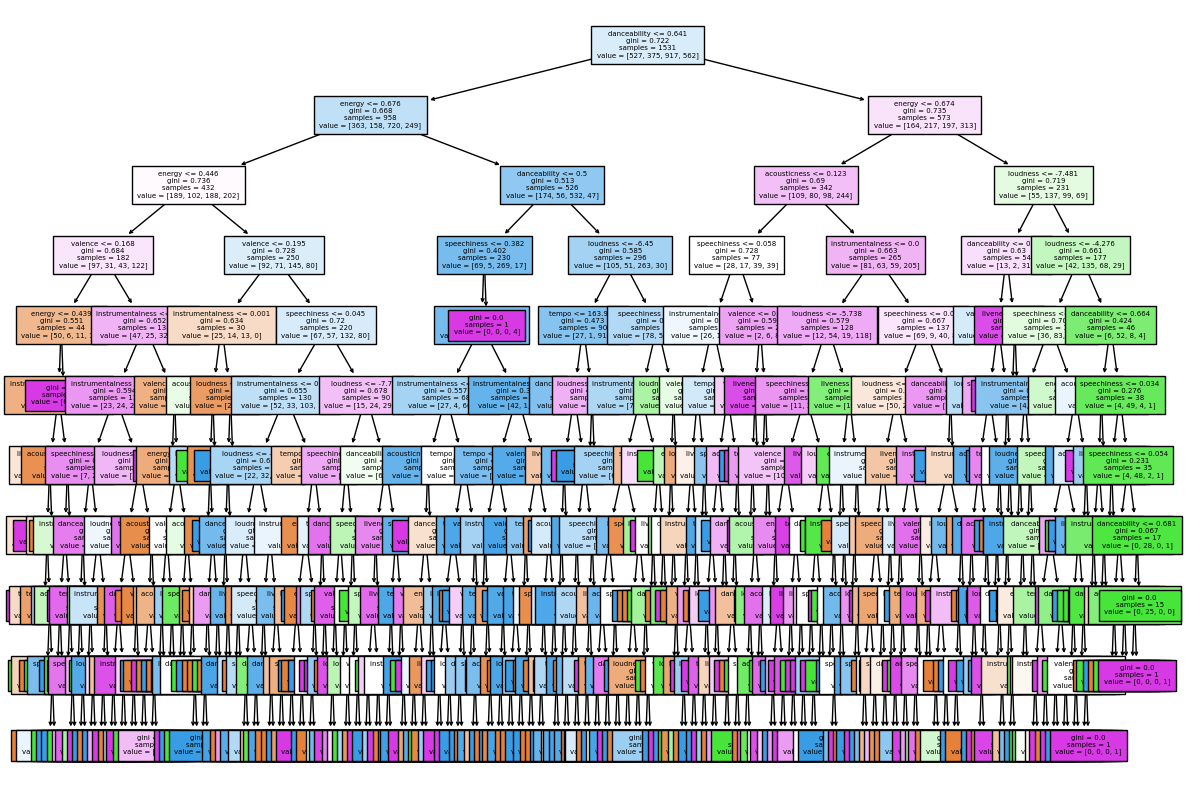

In [69]:
best_params = {k.split('__')[1]:v for k,v in model_grid_search.best_params_.items()}
rfc_best = RandomForestClassifier(random_state=42, **best_params)
rfc_best.fit(X_train, y_train)

# plot
plt.figure(figsize=(12,8)) 
plot_tree(rfc_best.estimators_[0],feature_names=X_train.columns, filled=True, fontsize=5)
plt.tight_layout()


Select best RF model

In [70]:
rfc_model_pipeline = model_grid_search.best_estimator_
rfc_model_pipeline

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('rfc',
                 RandomForestClassifier(max_depth=10, n_estimators=200,
                                        random_state=42))])

## Select Best Model

Generate genre predictions per best model

In [71]:
knn_y_pred = knn_model_pipeline.fit(X_train, y_train).predict(X_test)
svc_y_pred = svc_model_pipeline.fit(X_train, y_train).predict(X_test)
rfc_y_pred = rfc_model_pipeline.fit(X_train, y_train).predict(X_test)
xgb_y_pred = xgb_model_pipeline.fit(X_train, y_train).predict(X_test)


Generate classification report per best model

In [72]:
model_names = ['XGB','RF','KNN','SVM']
for i,y_pred in enumerate([xgb_y_pred, rfc_y_pred, knn_y_pred, svc_y_pred]):
    print('-------------------------------------------------------------')
    print(model_names[i])
    print(classification_report(y_test,
                                y_pred,
                                target_names=genre_lookup.values()))

-------------------------------------------------------------
XGB
              precision    recall  f1-score   support

       indie       0.45      0.30      0.36       131
         pop       0.54      0.54      0.54        81
        rock       0.62      0.70      0.66       244
        soul       0.57      0.64      0.60       140

    accuracy                           0.57       596
   macro avg       0.55      0.54      0.54       596
weighted avg       0.56      0.57      0.56       596

-------------------------------------------------------------
RF
              precision    recall  f1-score   support

       indie       0.53      0.25      0.34       131
         pop       0.56      0.53      0.54        81
        rock       0.62      0.76      0.68       244
        soul       0.60      0.68      0.64       140

    accuracy                           0.60       596
   macro avg       0.58      0.55      0.55       596
weighted avg       0.59      0.60      0.58       596


**Metrics**
- accuracy = % correct genre classifications
        all correct / all
- precision =  % correct genre classifications given everything model classified as that genre, emphasizes false positives
        TP/TP+FP 
- recall = % correct genre classifications given all actual tracks in the genre, emphasizes false negatives
        TP/TP+FN
- f1-score = weighted average of Precision and Recall
        F1 Score = 2*(Recall * Precision) / (Recall + Precision)
- support = number of items in the class

- macro ave = average of the unweighted mean per label
- weighted ave = average of the weighted mean per label


Plot confusion matrices

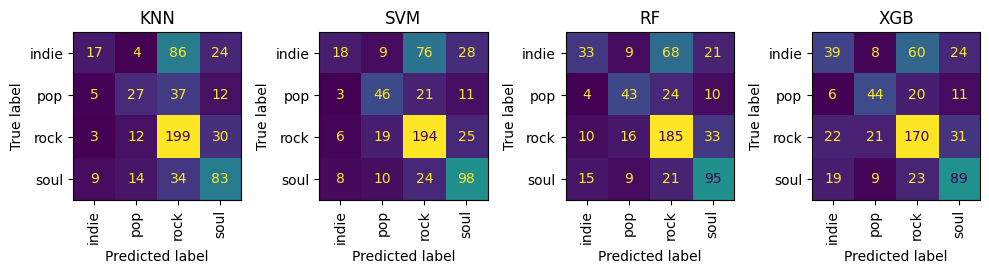

In [74]:
fig,axs = plt.subplots(1,4, figsize=(10,5))
model_names = ['KNN','SVM','RF', 'XGB']
for i,y_pred in enumerate([knn_y_pred, svc_y_pred, rfc_y_pred, xgb_y_pred]):
    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=list(genre_lookup.values()))
    cmd.plot(ax=axs[i], xticks_rotation=90, colorbar=False)
    axs[i].set_title(model_names[i])
plt.tight_layout()


>Q: Which model performed best? 

Store best model

In [95]:
best_model_pipeline = rfc_model_pipeline

In [96]:
best_model = best_model_pipeline.named_steps['rfc']
best_model_scaler = best_model_pipeline.named_steps['scaler']

In [75]:
# best_model_pipeline = svc_model_pipeline

In [77]:
# best_model = best_model_pipeline.named_steps['svc']
# best_model_scaler = best_model_pipeline.named_steps['scaler']

In [97]:
best_model_pipeline

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('rfc',
                 RandomForestClassifier(max_depth=10, n_estimators=200,
                                        random_state=42))])

Add predictions as columns to `tracks_df`

In [98]:
tracks_df['predicted_genre_id'] = best_model_pipeline.predict(tracks_df[feature_cols])
tracks_df['predicted_genre'] = tracks_df['predicted_genre_id'].map(genre_lookup)
tracks_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,genre,genre_id,predicted_genre_id,predicted_genre
0,57JVGBtBLCfHw2muk5416J,Another One Bites The Dust - Remastered 2011,1dfeR4HaWDbWqFHLkxsg1d,Queen,6wPXUmYJ9mOWrKlLzZ5cCa,214653,1980-06-27,74,0.933,0.528,...,0.329000,0.1630,0.756,109.975,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock,2,3,soul
4,2zYzyRzz6pRmhPzyfMEC8s,Highway to Hell,711MCceyCBcFnzjGY4Q7Un,AC/DC,10v912xgTZbjAtYfyKWJCS,208400,1979-07-27,84,0.574,0.913,...,0.001580,0.1560,0.423,115.728,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock,2,2,rock
8,3YBZIN3rekqsKxbJc9FZko,Paradise City,3qm84nBOXUEQ2vnTfUTTFC,Guns N' Roses,3I9Z1nDCL4E0cP62flcbI5,405640,1987-07-21,79,0.273,0.952,...,0.011100,0.1420,0.472,100.271,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock,2,2,rock
12,39shmbIHICJ2Wxnk1fPSdz,Should I Stay or Should I Go - Remastered,3RGLhK1IP9jnYFH4BRFJBS,The Clash,1ZH5g1RDq3GY1OvyD0w0s2,188986,1982,79,0.743,0.836,...,0.000000,0.3840,0.820,113.375,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock,2,2,rock
16,2Cdvbe2G4hZsnhNMKyGrie,I Love Rock 'N Roll,1Fmb52lZ6Jv7FMWXXTPO3K,Joan Jett & The Blackhearts,555qwe1qUgLdee80TZ2CQt,175173,1981-11-18,77,0.535,0.716,...,0.000000,0.6590,0.901,94.379,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock,2,2,rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,45nbChzfUPP8GO4rMthTNv,Imagina,1mX1TWKpNxDSAH16LgDfiR,Jesse & Joy,1yN7RC8f5hMASKpgvEHRDC,224066,2022-05-05,56,0.572,0.613,...,0.000946,0.2590,0.318,101.909,37i9dQZF1DX4YhSbTs17ha,Sólo Pop,pop,1,2,rock
670,0UXlu64mDLvfzR8IXMz06J,Ya No Somos Ni Seremos,0XwVARXT135rw8lyw1EeWP,Christian Nodal,6uU8vskychc3SuYYI9Hjbo,185722,2022-02-18,82,0.588,0.452,...,0.000000,0.3440,0.734,139.953,37i9dQZF1DX4YhSbTs17ha,Sólo Pop,pop,1,1,pop
671,7Dk8r4VR5NoveUvTiCKEXC,Pegao,28gNT5KBp7IjEOQoevXf9N,Camilo,2BzQoZdHURkzdFErSQ2Qll,160733,2022-05-19,68,0.807,0.499,...,0.000000,0.1040,0.867,90.037,37i9dQZF1DX4YhSbTs17ha,Sólo Pop,pop,1,1,pop
1297,1R0a2iXumgCiFb7HEZ7gUE,Don’t Blame Me,06HL4z0CvFAxyc27GXpf02,Taylor Swift,6DEjYFkNZh67HP7R9PSZvv,236413,2017-11-10,88,0.615,0.534,...,0.000018,0.0607,0.193,135.917,37i9dQZF1DX3WvGXE8FqYX,Women of Pop,pop,1,1,pop


## Feature Importance

Use scaler from pipeline to transform

In [101]:
features = best_model_scaler.transform(X_train)

Run SHAP explainer and get importance values

In [102]:
best_model

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

100%|██████████| 2381/2381 [04:27<00:00,  8.91it/s]


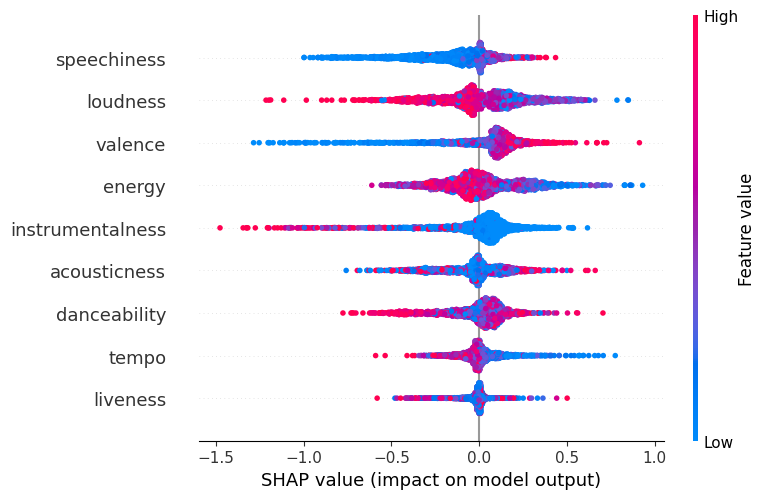

In [104]:
# Create a function to convert feature names to feature indices
feat_to_index = {feat: i for i, feat in enumerate(feature_cols)}

# Create a function to convert predicted class labels to class indices
label_to_index = {label: i for i, label in enumerate(genre_lookup.values())}

# Select a random subset of 10 rows from the features array as the background data
background_indices = np.random.choice(features.shape[0], size=10, replace=False)
background = features[background_indices, :]

# Create a kernel explainer with the trained SVM model and feature data
explainer = shap.KernelExplainer(best_model.predict, background)

# Calculate the SHAP values for the feature data
shap_values = explainer.shap_values(features)

# Plot the summary plot of SHAP values for each feature and class
shap.summary_plot(shap_values, features, feature_names=feature_cols, class_names=list(genre_lookup.values()))


In [ ]:
# explainer = shap.TreeExplainer(best_model, feature_names=feature_cols)
# shap_values = explainer.shap_values(features)

In [ ]:
# shap.summary_plot(shap_values=shap_values, 
#                   features = features,
#                   feature_names = feature_cols,
#                   class_names = list(genre_lookup.values()),
#                   plot_type = "bar")

>Q: Pick a track and verify as a listener if you agree with the predicted genre and how shap explains it

In [100]:
# Get sample track and index, scale features
sample = tracks_df[tracks_df['track_name'].str.contains('Creep')]
sample_idx = sample.index.values[0]
sample_features = best_model_scaler.transform(sample[feature_cols])
sample

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,genre,genre_id,predicted_genre_id,predicted_genre
23,70LcF31zb1H0PyJoS1Sx1r,Creep,4Z8W4fKeB5YxbusRsdQVPb,Radiohead,3gBVdu4a1MMJVMy6vwPEb8,238640,1993-02-22,84,0.515,0.43,...,0.000133,0.129,0.104,91.844,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock,2,2,rock


In [ ]:
# # Plot force plot per genre
# shap_values = explainer.shap_values(sample_features)
# shap.initjs()
# for genre_id in range(4):
#     print(genre_lookup[genre_id])
#     display(shap.force_plot(explainer.expected_value[genre_id], shap_values[genre_id], sample_features,\
#                              feature_names=feature_cols))
    

## Check misclassfied tracks in training data

>Q: How many tracks had different tagged and predicted genres? 

In [93]:
tracks_df[tracks_df['genre_id'] != tracks_df['predicted_genre_id']]

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,genre,genre_id,predicted_genre_id,predicted_genre
0,57JVGBtBLCfHw2muk5416J,Another One Bites The Dust - Remastered 2011,1dfeR4HaWDbWqFHLkxsg1d,Queen,6wPXUmYJ9mOWrKlLzZ5cCa,214653,1980-06-27,74,0.933,0.528,...,0.329000,0.1630,0.756,109.975,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock,2,3,soul
12,39shmbIHICJ2Wxnk1fPSdz,Should I Stay or Should I Go - Remastered,3RGLhK1IP9jnYFH4BRFJBS,The Clash,1ZH5g1RDq3GY1OvyD0w0s2,188986,1982,79,0.743,0.836,...,0.000000,0.3840,0.820,113.375,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock,2,1,pop
28,0ofHAoxe9vBkTCp2UQIavz,Dreams - 2004 Remaster,08GQAI4eElDnROBrJRGE0X,Fleetwood Mac,0BwWUstDMUbgq2NYONRqlu,257800,1977-02-04,84,0.828,0.492,...,0.004280,0.1280,0.789,120.151,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock,2,3,soul
33,70YvYr2hGlS01bKRIho1HM,La Grange - 2005 Remaster,2AM4ilv6UzW0uMRuqKtDgN,ZZ Top,0Em8m9kRctyH9S3MTXAHvY,230480,1973-07-26,76,0.545,0.640,...,0.030400,0.1960,0.606,80.544,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock,2,3,soul
54,2sXp9Qmvc7mRaDBjBgcGGi,Every Breath You Take - Remastered 2003,5NGO30tJxFlKixkPSgXcFE,The Police,7yDxJXFPl88Dt9kBo0dDD6,253886,1983-06-01,1,0.813,0.460,...,0.010500,0.0724,0.729,117.387,37i9dQZF1DWXRqgorJj26U,Rock Classics,rock,2,3,soul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,3fjN3y5x4hN53rykAN2LHQ,cómo dormiste?,2IMZYfNi21MGqxopj9fWx8,Rels B,2jt6z03JV7Ax8ZdlOrs9BK,112572,2022-08-04,84,0.627,0.429,...,0.000000,0.1220,0.565,126.426,37i9dQZF1DX4YhSbTs17ha,Sólo Pop,pop,1,3,soul
666,4vyg50FAJjpCQEwmJMxlv1,Un Nuevo Amor,77aLk6J8ofnVxa1eXK9jiU,Matisse,0qRYR5QyvLEt16G7UisMS2,226776,2022-04-01,65,0.622,0.465,...,0.000000,0.1580,0.569,76.076,37i9dQZF1DX4YhSbTs17ha,Sólo Pop,pop,1,3,soul
667,4zgVoY40iiq9XLu8V9Q9kb,Somos Instantes,2z3KntXLyEF5Lvz1kpdBoA,Caloncho,4La0StHyt6pRXr85FXRxgH,193413,2022-04-27,61,0.801,0.402,...,0.382000,0.0973,0.646,75.005,37i9dQZF1DX4YhSbTs17ha,Sólo Pop,pop,1,0,indie
669,45nbChzfUPP8GO4rMthTNv,Imagina,1mX1TWKpNxDSAH16LgDfiR,Jesse & Joy,1yN7RC8f5hMASKpgvEHRDC,224066,2022-05-05,56,0.572,0.613,...,0.000946,0.2590,0.318,101.909,37i9dQZF1DX4YhSbTs17ha,Sólo Pop,pop,1,2,rock


Pick one among these tracks and use `shap.force_plot` to understand why the model classified it to another genre

In [94]:
sample = tracks_df[tracks_df['genre_id'] != tracks_df['predicted_genre_id']].sample(1)
sample_idx = sample.index.values[0]
sample_features = best_model_scaler.transform(sample[feature_cols])
print(sample.iloc[0])

track_id              0Z57YWES04xGh3AImDz6Qr
track_name                    Real Love Baby
artist_id             2kGBy2WHvF0VdZyqiVCkDT
artist_name                Father John Misty
album_id              75614DWrksimeV4oXUhaYP
duration                              189293
release_date                      2016-07-26
popularity                                71
danceability                           0.417
energy                                 0.686
key                                      7.0
loudness                              -6.484
mode                                     1.0
speechiness                           0.0373
acousticness                          0.0955
instrumentalness                      0.0287
liveness                              0.0989
valence                                0.625
tempo                                204.113
playlist_id           37i9dQZF1DX9B1hu73DioC
playlist_name                 Indie Chillout
genre                                  indie
genre_id  

In [ ]:
# # Plot force plot per genre
# shap_values = explainer.shap_values(sample_features)
# shap.initjs()

# for genre_id in range(6):
#     print(genre_lookup[genre_id])
#     display(shap.force_plot(explainer.expected_value[genre_id],
#                             shap_values[genre_id],
#                             sample_features,
#                             feature_names=feature_cols))

## Save the Pipeline

In [86]:
best_model_pipeline

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('svc', SVC(C=1000, degree=2, gamma=0.1, kernel='poly'))])

In [87]:
# joblib.dump(best_model_pipeline,'../model/genre_classifier_4t_svm_poly.pkl')

['../model/genre_classifier_4t_svm_poly.pkl']

In [99]:
joblib.dump(best_model_pipeline,'../model/genre_classifier_4t_rf.pkl')

['../model/genre_classifier_4t_rf.pkl']